In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from typing import *

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 150)
pd.set_option('display.max_colwidth', None)
pd.set_option('future.no_silent_downcasting', True)
sns.set()

df = pd.read_csv('data_part_2.csv')

print(df.shape)
df.head()

(1009, 18)


,user_id,region,device,channel,session_start,session_end,sessiondurationsec,session_date,month,day,hour_of_day,order_dt,revenue,payment_type,promo_code,final_price,time_of_day,sold
0,529697267522,United States,iPhone,социальные сети,2019-05-01 00:06:40,2019-05-01 00:07:06,26.0,2019-05-01,5,3,0,2019-05-01 00:06:40,9999.0,Mobile payments,0.0,9999.0,night,1
1,601292388085,United States,PC,organic,2019-05-01 06:56:16,2019-05-01 07:09:18,782.0,2019-05-01,5,3,7,NaN,NaN,NaN,NaN,NaN,morning,0
2,852898876338,United States,Mac,социальные сети,2019-05-01 04:30:45,2019-05-01 04:34:56,251.0,2019-05-01,5,3,4,NaN,NaN,NaN,NaN,NaN,night,0
3,998513020664,United States,iPhone,социальные сети,2019-05-01 18:53:42,2019-05-01 18:57:35,233.0,2019-05-01,5,3,18,NaN,NaN,NaN,NaN,NaN,evening,0
4,240702200943,United States,Mac,социальные сети,2019-05-02 14:04:32,2019-05-02 14:09:51,319.0,2019-05-02,5,4,14,NaN,NaN,NaN,NaN,NaN,day,0


# Set Proper Data Types

In [2]:
dtype_mapping = {
    'user_id': 'int64', 
    'region': 'object', 
    'device': 'object', 
    'channel': 'object', 
    'session_start': 'datetime64[ns]', 
    'session_end': 'datetime64[ns]', 
    'sessiondurationsec': 'float64', 
    'session_date': 'datetime64[ns]', 
    'month': 'int64', 
    'day': 'int64', 
    'hour_of_day': 'int64', 
    'order_dt': 'datetime64[ns]', 
    'revenue': 'float64', 
    'payment_type': 'object', 
    'promo_code': 'float64'
}

df = df.astype(dtype_mapping)

# 1. Data Preparation:

In [4]:
def calculate_average_revenue(df, metric_type='aov', groupby_cols=['region']):
    """
    Calculates AOV or ARPU by specified grouping.
    
    Parameters
    ----------
    df : DataFrame
        Raw data
    metric_type : str
        'aov' - Average Order Value (revenue per order for paying users)
        'arpu' - Average Revenue Per User (revenue per all users, including non-paying)
    groupby_cols : list
        Columns to group by
        
    Returns
    -------
    Series with average values
    """
    if metric_type == 'aov':
        # Only consider actual purchases (non-NaN revenue)
        avg_values = (df[df['revenue'].notna()]
                     .groupby(groupby_cols)['revenue']
                     .mean()
                     .round(2))
    else:  # ARPU
        # Fill NaN with 0 to include non-paying users
        df_calc = df.copy()
        df_calc['revenue'] = df_calc['revenue'].fillna(0)
        avg_values = (df_calc.groupby(groupby_cols)['revenue']
                     .mean()
                     .round(2))
    
    return avg_values

# Calculate both metrics
aov_by_region = calculate_average_revenue(df, metric_type='aov')
arpu_by_region = calculate_average_revenue(df, metric_type='arpu')

print("AOV by region:")
print(aov_by_region)
print("\nARPU by region:")
print(arpu_by_region)

AOV by region:
region
France           5729.77
Germany          5479.00
UK               5734.29
United States    5608.14
Name: revenue, dtype: float64

ARPU by region:
region
France           1432.44
Germany          1329.85
UK               1666.38
United States    1612.85
Name: revenue, dtype: float64


# Check for normality:

Normality test results:
          region  n_orders         mean  shapiro_stat       p_value  normal
0  United States       197  5608.137056      0.474858  7.906179e-24   False
1        Germany        25  5479.000000      0.482843  2.543837e-08   False
2         France        26  5729.769231      0.549744  8.179838e-08   False
3             UK        34  5734.294118      0.537228  3.357142e-09   False


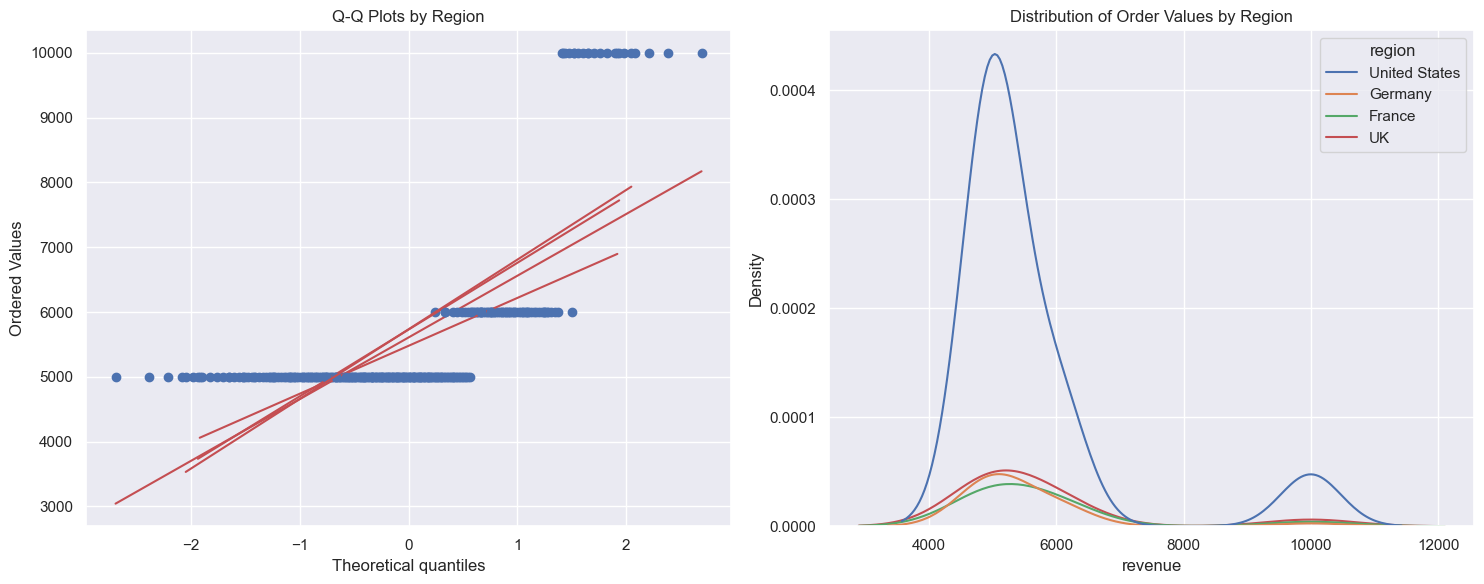

In [5]:
def test_order_values_normality(df):
    """
    Tests normality of order values for each region.
    
    Returns
    -------
    DataFrame
        Shapiro-Wilk test results for each region
    """
    # Get only actual purchases
    orders = df[df['revenue'].notna()].copy()
    
    results = []
    for region in orders['region'].unique():
        region_values = orders[orders['region'] == region]['revenue']
        
        # Shapiro-Wilk test
        stat, pval = stats.shapiro(region_values)
        
        results.append({
            'region': region,
            'n_orders': len(region_values),
            'mean': region_values.mean(),
            'shapiro_stat': stat,
            'p_value': pval,
            'normal': pval > 0.05
        })
    
    return pd.DataFrame(results)

# Test normality
normality_results = test_order_values_normality(df)
print("Normality test results:")
print(normality_results)

# Also create QQ and density plots
plt.figure(figsize=(15, 6))

# QQ plot
plt.subplot(1, 2, 1)
for region in df['region'].unique():
    region_values = df[df['region'] == region]['revenue'].dropna()
    stats.probplot(region_values, dist="norm", plot=plt)
plt.title('Q-Q Plots by Region')

# Density plot
plt.subplot(1, 2, 2)
orders = df[df['revenue'].notna()]
sns.kdeplot(data=orders, x='revenue', hue='region')
plt.title('Distribution of Order Values by Region')

plt.tight_layout()
plt.show()

# Since all regions show non-normal distribution (all p-values < 0.05), we should use the Kruskal-Wallis test to compare order values across regions.

In [6]:
def test_regional_order_values(df):
    """
    Tests differences in order values across regions using Kruskal-Wallis test.
    
    Returns
    -------
    dict with test results and summary statistics
    """
    # Get order values by region
    orders = df[df['revenue'].notna()].copy()
    
    # Kruskal-Wallis test
    regions = [group['revenue'].values 
              for _, group in orders.groupby('region')]
    
    stat, pval = stats.kruskal(*regions)
    
    # Get summary statistics
    region_stats = orders.groupby('region')['revenue'].agg(['count', 'mean', 'median'])
    
    return {
        'statistic': stat,
        'p_value': pval,
        'significant': pval < 0.05,
        'region_stats': region_stats
    }

results = test_regional_order_values(df)
print("Kruskal-Wallis test results:")
print(f"Statistic: {results['statistic']:.4f}")
print(f"P-value: {results['p_value']:.4f}")
print(f"Significant: {results['significant']}")
print("\nRegion statistics:")
print(results['region_stats'])

Kruskal-Wallis test results:
Statistic: 2.4769
P-value: 0.4795
Significant: False

Region statistics:
               count         mean  median
region                                   
France            26  5729.769231  4999.0
Germany           25  5479.000000  4999.0
UK                34  5734.294118  4999.0
United States    197  5608.137056  4999.0


# The order values do NOT significantly differ across regions. This suggests that customers across all regions (USA, France, Germany, and UK) tend to make purchases of similar values, indicating consistent pricing and purchasing patterns across markets.

This finding could be valuable for business decisions, suggesting that pricing strategies and order values are well-standardized across different geographical markets.